# What is the most optimal skill to learn for Data Analysts?

*Methodology*

1. Find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalent

### Considering just the job postings where salary information is available

Now look at the most requested or the highest paid skills among the job postings that gives a salary estimate.
## Import Libraries and Data

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from datasets import load_dataset 
import matplotlib.pyplot as plt
import ast
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Cleaning Data
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

## Clean Data

Filters the original dataset to only get rows where the job title is 'Data Analyst' and the country is 'Italy', to create a new DataFrame `df_DA_it`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_DA_it_no_na`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [2]:
df_DA_it = df[(df['job_title_short']=='Data Analyst') & (df['job_country']=='Italy')].drop_duplicates(subset=["job_title","company_name"]).copy()

# Remove rows with absent salary column
df_DA_it_no_na = df_DA_it.dropna(subset='salary_year_avg').copy()

# Explode the new dataframe 
df_DA_it_no_na = df_DA_it_no_na.explode('job_skills')

df_DA_it_no_na[['salary_year_avg','job_skills']].head(5)

,salary_year_avg,job_skills
107484,89100.0,r
107484,89100.0,python
107484,89100.0,java
107484,89100.0,flow
180608,51014.0,bigquery


## Determine The Highest Paid Skills and Most Demanded Skills
Gets the top ten highest-paying skills for Data Analysts by calculating the median salary for each skill listed in the `df_DA_it_no_na`. It groups the data by job skills, computes the median salary, sorts these values in descending order by median, and then selects the top 10. This is then formatted into a new DataFrame (`df_DA_top_pay`) with a reset index and a renamed salary column labeled 'median_salary'.

In [3]:
# Find the 10 skills with highest median salary
df_DA_top_pay = df_DA_it_no_na.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='median',ascending=False)
df_DA_top_pay = df_DA_top_pay.head(10)
df_DA_top_pay

,count,median
job_skills,,
looker,1,102500.0
crystal,1,100500.0
qlik,1,100500.0
r,3,100500.0
sql,3,100500.0
tableau,3,100500.0
flow,1,89100.0
java,1,89100.0
python,5,89100.0


Calculates the count and median salary for each skill in `df_DA_it_no_na`. It groups the data by job_skills, aggregates it to find the count and median salary for each skill, and then sorts the results by count in descending order by count. It re-sorts this subset by median salary in descending order.

In [4]:
# Find the 10 most requested skills
df_DA_skills = df_DA_it_no_na.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count',ascending=False)
df_DA_skills = df_DA_skills.head(10)
df_DA_skills = df_DA_skills.sort_values(by='median',ascending=False)

df_DA_skills

,count,median
job_skills,,
r,3,100500.0
sql,3,100500.0
tableau,3,100500.0
crystal,1,100500.0
python,5,89100.0
flow,1,89100.0
java,1,89100.0
bigquery,2,75757.0
javascript,1,53014.0


Creates two horizontal bar charts:

1. Displays the highest paid skills
2. Shows the most in demand skills

### Focus: highlight interesting skills

Create a list of skills that I don't already know (and so that are not listed in `my_skills`) and are generally paid more than the mean pay of the skills that I know.

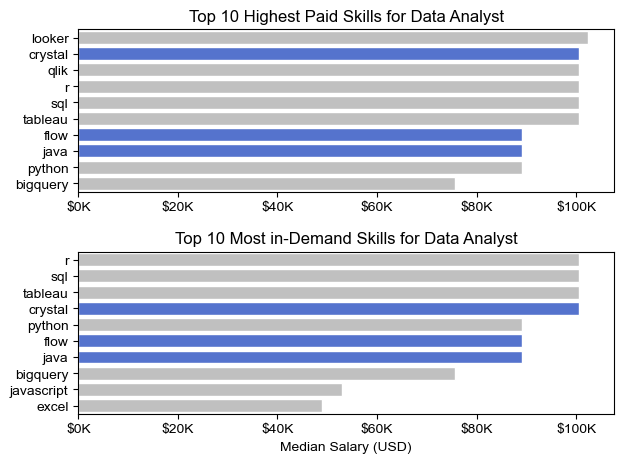

In [5]:
my_skills=['excel','python','sql','r','tableau']

# Highlight the most requested missing skills which are paid more than my skills
not_myskill_condition = ~df_DA_skills.index.isin(my_skills)
my_skills_salary = df_DA_skills.loc[df_DA_skills.index.isin(my_skills),'median'].mean()
higher_sal_condition = df_DA_skills['median']>my_skills_salary
highlight_skills = df_DA_skills.loc[higher_sal_condition & not_myskill_condition].index.to_list()

# Plot results

fig, ax = plt.subplots(2,1)
sns.set_theme(style='ticks')

# Finding index for skill to highlight in the top paid skills plot
cols = ['silver']*len(df_DA_top_pay)
highlight_indices = np.where(df_DA_top_pay.index.isin(highlight_skills))[0]
for idx in highlight_indices:
    cols[idx] = 'royalblue'

sns.barplot(data=df_DA_top_pay,x='median',y=df_DA_top_pay.index, ax=ax[0], hue=df_DA_top_pay.index,palette=cols,legend=False)
ax[0].set_title('Top 10 Highest Paid Skills for Data Analyst')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x/1000)}K'))

# Finding index for skill to highlight in the most requested skills plot
cols = ['silver']*len(df_DA_skills)
highlight_indices = np.where(df_DA_skills.index.isin(highlight_skills))[0]
for idx in highlight_indices:
    cols[idx] = 'royalblue' 

sns.barplot(data=df_DA_skills,x='median',y=df_DA_skills.index, ax=ax[1],hue=df_DA_skills.index,palette=cols,legend=False)
ax[1].set_xlim(ax[0].get_xlim()) #put same xlim of the other ax
ax[1].set_title('Top 10 Most in-Demand Skills for Data Analyst')
ax[1].set_xlabel('Median Salary (USD)')
ax[1].set_ylabel('')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x/1000)}K'))
fig.tight_layout()
plt.show()


## Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculates the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Data Analyst jobs. Finally, filter out any skills that don't have any jobs associated with them.

In [6]:
df_DA_skills = df_DA_it_no_na.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count', ascending=False)
df_DA_skills = df_DA_skills.rename(columns={'count':'skills_count','median':'median_salary'})
DA_job_count = len(df_DA_it_no_na)

df_DA_skills['skill_percent'] = df_DA_skills['skills_count']/DA_job_count *100
df_DA_skills

,skills_count,median_salary,skill_percent
job_skills,,,
python,5,89100.0,20.0
r,3,100500.0,12.0
sql,3,100500.0,12.0
tableau,3,100500.0,12.0
bigquery,2,75757.0,8.0
excel,2,49007.0,8.0
crystal,1,100500.0,4.0
flow,1,89100.0,4.0
java,1,89100.0,4.0


## Median Salary vs Percent Skill Demand

Filters for Data Analyst skills that exceed a certain percentage (`skill_percent`).

In [7]:
skill_percent = 2.5
df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent']>skill_percent]

Create a scatter plot to visualize the relationship between the percentage of Data Analyst jobs that require specific skills and the median salary for those skills. Filter just the skills which are not in the list `my_skills`

In [8]:
# Filter just the skills you don't already know 
new_skills=[]
for s in df_DA_skills_high_demand.index:
    if s not in my_skills:
        new_skills.append(s)

df_DA_skills_high_demand = df_DA_skills_high_demand.loc[new_skills]

## Bonus: Coloring by Technology

We're going to add color labels based on technology.

Removes duplicate entries and any rows with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.

In [9]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict



{'analyst_tools': ['sharepoint',
  'dax',
  'sheets',
  'excel',
  'looker',
  'alteryx',
  'microstrategy',
  'tableau',
  'powerpoint',
  'ms access',
  'sas',
  'power bi',
  'spss',
  'outlook',
  'msaccess',
  'qlik',
  'datarobot',
  'cognos',
  'visio',
  'esquisse',
  'ssrs',
  'powerbi',
  'spreadsheet',
  'ssis',
  'nuix',
  'sap',
  'splunk',
  'word'],
 'programming': ['r',
  'mongo',
  'assembly',
  'fortran',
  'visual basic',
  'f#',
  'javascript',
  't-sql',
  'ruby',
  'matlab',
  'lisp',
  'c#',
  'delphi',
  'objective-c',
  'go',
  'css',
  'c++',
  'apl',
  'c',
  'haskell',
  'cobol',
  'scala',
  'sas',
  'mongodb',
  'powershell',
  'python',
  'shell',
  'html',
  'dart',
  'clojure',
  'vba',
  'golang',
  'perl',
  'swift',
  'typescript',
  'rust',
  'julia',
  'nosql',
  'vb.net',
  'ocaml',
  'sql',
  'sass',
  'crystal',
  'solidity',
  'kotlin',
  'bash',
  'groovy',
  'java',
  'lua',
  'elixir',
  'pascal',
  'php',
  'no-sql',
  'visualbasic',
  'erl

This code converts a dictionary into a pandas DataFrame, then explodes the 'skills' column, creating multiple rows for each 'technology' entry if it contains multiple skills.

In [10]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,sharepoint
0,analyst_tools,dax
0,analyst_tools,sheets
0,analyst_tools,excel
0,analyst_tools,looker
...,...,...
9,sync,unify
9,sync,google chat
9,sync,webex
9,sync,mattermost


Merges two DataFrames, `df_DA_skills:high_demand` and `df_technology`, based on the columns 'job_skills' and 'skills' respectively, creating a new DataFrame `df_plot`.

In [11]:
df_plot = df_DA_skills_high_demand.merge(df_technology,left_on='job_skills',right_on='skills')

Plot the results in a scatter plot, coloring the points based on the 'technology' column.

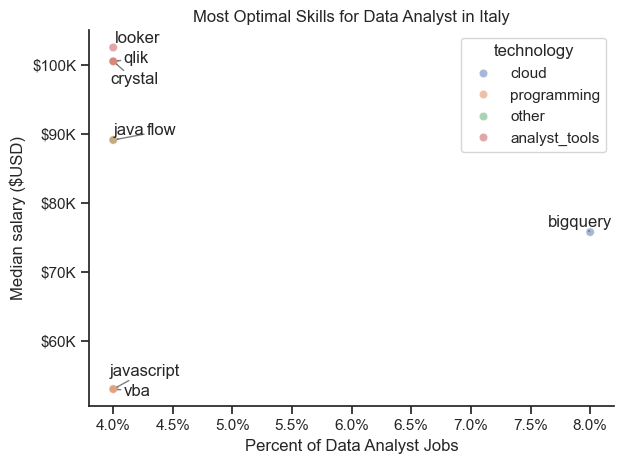

In [12]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

#df_plot.plot(kind='scatter',x='skill_percent',y='median_salary')
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology', 
    alpha=0.5
    )

ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos: f"${int(y/1000)}K"))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=1))

plt.ylabel('Median salary ($USD)')
plt.xlabel('Percent of Data Analyst Jobs')
plt.title('Most Optimal Skills for Data Analyst in Italy')
texts = []
for i,txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],df_DA_skills_high_demand['median_salary'].iloc[i],txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray',lw=1))
plt.tight_layout()
sns.despine()
sns.set_theme(style='ticks')
plt.show()